In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neural_network import MLPClassifier

In [3]:
# Task - 1

In [5]:
# Step 1: Load the Breast Cancer Wisconsin dataset
data = load_breast_cancer()
X = data.data
y = data.target

In [6]:
# Step 2: Inspect the data
print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)
print("Number of features:", len(data.feature_names))
print("Feature names:\n", data.feature_names)
print("\nThis is a binary classification problem.\n")

Feature matrix shape: (569, 30)
Target vector shape: (569,)
Number of features: 30
Feature names:
 ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']

This is a binary classification problem.



In [7]:
# Step 3: Create Hold-Out Set (70% train / 30% validation)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42
)


In [8]:
# Step 4: Standardize features (important for neural networks)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)


In [10]:
# Task - 2

In [11]:

# Activation functions
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def relu(Z):
    return np.maximum(0, Z)

# Activation derivatives
def sigmoid_derivative(A):
    return A * (1 - A)

def relu_derivative(Z):
    return (Z > 0).astype(int)


In [12]:
# Loss functions
def compute_bce_loss(Y, Y_hat):
    epsilon = 1e-15  # for numerical stability
    Y_hat = np.clip(Y_hat, epsilon, 1 - epsilon)
    m = Y.shape[1]
    loss = -np.sum(Y * np.log(Y_hat) + (1 - Y) * np.log(1 - Y_hat)) / m
    return loss

def compute_mse_loss(Y, Y_hat):
    m = Y.shape[1]
    return np.sum((Y - Y_hat) ** 2) / (2 * m)


In [13]:
# Task 3

In [14]:
class MyANNClassifier:
    def __init__(self, layer_dims, learning_rate=0.01, n_iterations=1000, loss='bce'):
        self.layer_dims = layer_dims
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.loss = loss
        self.parameters_ = {}
        self.costs_ = []

    # Parameter Initialization
    def _initialize_parameters(self):
        np.random.seed(42)
        for l in range(1, len(self.layer_dims)):
            self.parameters_['W' + str(l)] = np.random.randn(
                self.layer_dims[l], self.layer_dims[l - 1]
            ) * 0.01
            self.parameters_['b' + str(l)] = np.zeros((self.layer_dims[l], 1))

    # Forward Propagation
    def _forward_propagation(self, X):
        cache = []
        A = X
        L = len(self.layer_dims) - 1
        for l in range(1, L + 1):
            W = self.parameters_['W' + str(l)]
            b = self.parameters_['b' + str(l)]
            Z = np.dot(W, A) + b

            if l < L:
                A = relu(Z)
            else:
                A = sigmoid(Z)

            cache.append((A, Z))
        return A, cache

    # Backward Propagation
    def _backward_propagation(self, Y, Y_hat, cache):
        grads = {}
        L = len(self.layer_dims) - 1
        m = Y.shape[1]

        # Initialize derivative of loss wrt Y_hat
        if self.loss == 'bce':
            dA = -(np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat))
        else:
            dA = 2 * (Y_hat - Y)

        for l in reversed(range(1, L + 1)):
            A, Z = cache[l - 1]
            A_prev = cache[l - 2][0] if l > 1 else X_train_scaled.T
            W = self.parameters_['W' + str(l)]

            if l == L:
                dZ = dA * sigmoid_derivative(A)
            else:
                dZ = dA * relu_derivative(Z)

            dW = np.dot(dZ, A_prev.T) / m
            db = np.sum(dZ, axis=1, keepdims=True) / m
            dA = np.dot(W.T, dZ)

            grads['dW' + str(l)] = dW
            grads['db' + str(l)] = db

        return grads

    # Parameter Update
    def _update_parameters(self, grads):
        for l in range(1, len(self.layer_dims)):
            self.parameters_['W' + str(l)] -= self.learning_rate * grads['dW' + str(l)]
            self.parameters_['b' + str(l)] -= self.learning_rate * grads['db' + str(l)]

    # Fit Method
    def fit(self, X, y):
        X = X.T
        y = y.reshape(1, -1)
        self._initialize_parameters()

        for i in range(self.n_iterations):
            Y_hat, cache = self._forward_propagation(X)
            loss = compute_bce_loss(y, Y_hat) if self.loss == 'bce' else compute_mse_loss(y, Y_hat)
            grads = self._backward_propagation(y, Y_hat, cache)
            self._update_parameters(grads)

            if i % 500 == 0:
                self.costs_.append(loss)
                print(f"Iteration {i} | Loss: {loss:.5f}")

    # Predict Method
    def predict(self, X):
        X = X.T
        Y_hat, _ = self._forward_propagation(X)
        predictions = (Y_hat > 0.5).astype(int)
        return predictions.flatten()

In [15]:
# Task 4

In [16]:
# Model 1: BCE Loss, one hidden layer
print("=== Model 1: BCE Loss, Architecture [30, 10, 1] ===")
model1 = MyANNClassifier(layer_dims=[30, 10, 1], learning_rate=0.001, n_iterations=5000, loss='bce')
model1.fit(X_train_scaled, y_train)
preds1 = model1.predict(X_val_scaled)
print(classification_report(y_val, preds1))
print("Accuracy:", accuracy_score(y_val, preds1), "\n")

=== Model 1: BCE Loss, Architecture [30, 10, 1] ===
Iteration 0 | Loss: 0.69318
Iteration 500 | Loss: 0.68594
Iteration 1000 | Loss: 0.68012
Iteration 1500 | Loss: 0.67518
Iteration 2000 | Loss: 0.67049
Iteration 2500 | Loss: 0.66512
Iteration 3000 | Loss: 0.65743
Iteration 3500 | Loss: 0.64445
Iteration 4000 | Loss: 0.62107
Iteration 4500 | Loss: 0.58055
              precision    recall  f1-score   support

           0       1.00      0.65      0.79        63
           1       0.83      1.00      0.91       108

    accuracy                           0.87       171
   macro avg       0.92      0.83      0.85       171
weighted avg       0.89      0.87      0.86       171

Accuracy: 0.8713450292397661 



In [17]:
# Model 2: MSE Loss, same architecture
print("=== Model 2: MSE Loss, Architecture [30, 10, 1] ===")
model2 = MyANNClassifier(layer_dims=[30, 10, 1], learning_rate=0.001, n_iterations=5000, loss='mse')
model2.fit(X_train_scaled, y_train)
preds2 = model2.predict(X_val_scaled)
print(classification_report(y_val, preds2))
print("Accuracy:", accuracy_score(y_val, preds2), "\n")

=== Model 2: MSE Loss, Architecture [30, 10, 1] ===
Iteration 0 | Loss: 0.12501
Iteration 500 | Loss: 0.12405
Iteration 1000 | Loss: 0.12320
Iteration 1500 | Loss: 0.12244
Iteration 2000 | Loss: 0.12175
Iteration 2500 | Loss: 0.12112
Iteration 3000 | Loss: 0.12053
Iteration 3500 | Loss: 0.11995
Iteration 4000 | Loss: 0.11938
Iteration 4500 | Loss: 0.11876
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        63
           1       0.63      1.00      0.77       108

    accuracy                           0.63       171
   macro avg       0.32      0.50      0.39       171
weighted avg       0.40      0.63      0.49       171

Accuracy: 0.631578947368421 



C:\Users\gupta\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gupta\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gupta\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [18]:
# Model 3: BCE Loss, deeper architecture
print("=== Model 3: BCE Loss, Architecture [30, 10, 5, 1] ===")
model3 = MyANNClassifier(layer_dims=[30, 10, 5, 1], learning_rate=0.001, n_iterations=5000, loss='bce')
model3.fit(X_train_scaled, y_train)
preds3 = model3.predict(X_val_scaled)
print(classification_report(y_val, preds3))
print("Accuracy:", accuracy_score(y_val, preds3), "\n")

=== Model 3: BCE Loss, Architecture [30, 10, 5, 1] ===
Iteration 0 | Loss: 0.69314
Iteration 500 | Loss: 0.68616
Iteration 1000 | Loss: 0.68072
Iteration 1500 | Loss: 0.67648
Iteration 2000 | Loss: 0.67317
Iteration 2500 | Loss: 0.67059
Iteration 3000 | Loss: 0.66857
Iteration 3500 | Loss: 0.66700
Iteration 4000 | Loss: 0.66576
Iteration 4500 | Loss: 0.66479
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        63
           1       0.63      1.00      0.77       108

    accuracy                           0.63       171
   macro avg       0.32      0.50      0.39       171
weighted avg       0.40      0.63      0.49       171

Accuracy: 0.631578947368421 



C:\Users\gupta\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gupta\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gupta\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

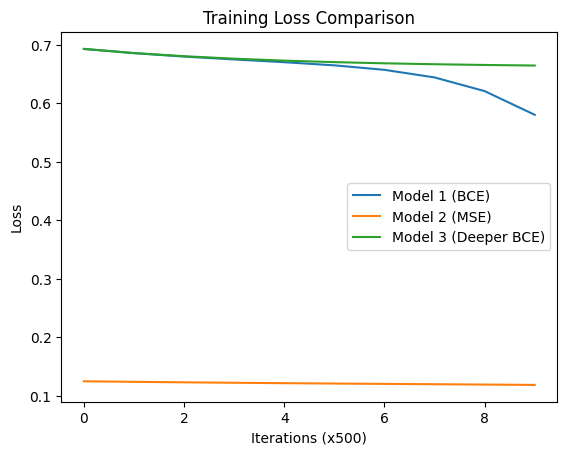

In [19]:
# Plot training loss
plt.plot(model1.costs_, label='Model 1 (BCE)')
plt.plot(model2.costs_, label='Model 2 (MSE)')
plt.plot(model3.costs_, label='Model 3 (Deeper BCE)')
plt.xlabel("Iterations (x500)")
plt.ylabel("Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.show()

In [20]:
# Task - 5

In [21]:

print("=== Model 4: sklearn MLPClassifier ===")
mlp = MLPClassifier(
    hidden_layer_sizes=(10,),
    activation='relu',
    solver='adam',
    learning_rate_init=0.001,
    max_iter=1000,
    random_state=42
)

=== Model 4: sklearn MLPClassifier ===


In [22]:
mlp.fit(X_train_scaled, y_train)
mlp_preds = mlp.predict(X_val_scaled)
print(classification_report(y_val, mlp_preds))
print("Accuracy:", accuracy_score(y_val, mlp_preds), "\n")


              precision    recall  f1-score   support

           0       0.98      0.98      0.98        63
           1       0.99      0.99      0.99       108

    accuracy                           0.99       171
   macro avg       0.99      0.99      0.99       171
weighted avg       0.99      0.99      0.99       171

Accuracy: 0.9883040935672515 

